In [1]:
using Plots

In [2]:
mutable struct Particles
    n :: Int
    pos :: AbstractArray{Float64, 2}
    vel :: AbstractArray{Float64, 2}
end

In [65]:
function gravity(particles::Particles) :: AbstractArray{Float64, 2}
    vec_x = particles.pos[1, :] .- particles.pos[1, :]'
    vec_y = particles.pos[2, :] .- particles.pos[2, :]'
    vec_z = particles.pos[3, :] .- particles.pos[3, :]'

    r_sq = (vec_x.^2 + vec_y.^2 + vec_z.^2) .+ 1e-6

    force_x = -vec_x ./ r_sq
    force_y = -vec_y ./ r_sq
    force_z = -vec_z ./ r_sq

    force_x = sum(force_x, dims=2)
    force_y = sum(force_y, dims=2)
    force_z = sum(force_z, dims=2)

    force = [force_x force_y force_z]

    return transpose(force)
end

gravity (generic function with 2 methods)

In [118]:
function euler(particles::Particles, dt::Float64, sign::Int)
    force = gravity(particles) .* sign
    particles.vel .+= force .* dt
    particles.pos .+= particles.vel .* dt
end

euler (generic function with 1 method)

In [133]:
n_particles = 100
n_steps = 400
n_dims = 3
dt = 0.0004

particles = Particles(n_particles, rand(n_dims, n_particles), rand(n_dims, n_particles))

particles_fwd = zeros(n_dims, n_particles, n_steps)
particles_bwd = zeros(n_dims, n_particles, n_steps)

# do the forward simulation
for i in 1:n_steps
    euler(particles, dt, 1)
    particles_fwd[:, :, i] = particles.pos
end

# do the backward simulation
# invert the velocity
particles.vel = -particles.vel
for i in 1:n_steps
    euler(particles, dt, -1)
    particles_bwd[:, :, i] = particles.pos
end


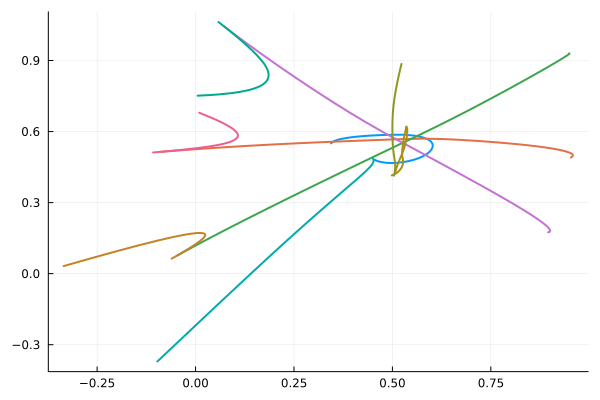

In [134]:
num_plots = 5
stride = 10
# plot a 2d projection of the particle trajectories
plot(transpose(particles_fwd[1, 1:num_plots, 1:stride:end]), transpose(particles_fwd[2, 1:num_plots, 1:stride:end]), lw=2, legend=false)
# add the backward trajectories
plot!(transpose(particles_bwd[1, 1:num_plots, 1:stride:end]), transpose(particles_bwd[2, 1:num_plots, 1:stride:end]), lw=2, legend=false)
